# Surface Classification - Recurrent Neural Network

Here we use a type of RNN called an LSTM to classify which surface a Turtlebot3 Robot is driving on. We use two different types of tile, carpet, and turf. 

In [1]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, chi2

import plotly as ply
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib notebook

#os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow.keras import backend as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1L2



pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 80)

In [2]:
# Key parameters
numFramesLookback = 64
numShiftedFrameSets = 16
numEpochs = 80
batchSize = 256

## Data Loading & Preprocessing
We load in individual csv files collected from Rosbags on TurtleBot3 with ROS. THese csv files contain time series data for the various sensors on the robot. 

In [3]:
dataFolder = r"/media/jacob/Storage/Experiment3Data-2019-11-21"

dataFiles = [
    r"gMitTile_s15_t8.csv",
    r"gMitTile_s15_t9.csv",
    r"gMitTile_s15_t10.csv",
    r"gTurf_s15_t3.csv",
    r"gTurf_s15_t4.csv",
    r"gTurf_s15_t5.csv",
    r"gTurf_s15_t6.csv",
    r"gTurf_s15_t7.csv",
    r"gTurf_s15_t8.csv",
    r"gTurf_s15_t9.csv",
    r"gTurf_s15_t10.csv",
    r"gArcTile_s15_t3.csv",
    r"gArcTile_s15_t4.csv",
    r"gArcTile_s15_t5.csv",
    r"gArcTile_s15_t6.csv",
    r"gArcTile_s15_t7.csv",
    r"gArcTile_s15_t8.csv",
    r"gArcTile_s15_t9.csv",
    r"gArcTile_s15_t10.csv",
    r"gCarp_s15_t3.csv",
    r"gCarp_s15_t4.csv",
    r"gCarp_s15_t5.csv",
    r"gCarp_s15_t6.csv",
    r"gCarp_s15_t7.csv",
    r"gCarp_s15_t8.csv",
    r"gCarp_s15_t9.csv",
    r"gCarp_s15_t10.csv",
    r"gMitTile_s15_t3.csv",
    r"gMitTile_s15_t4.csv",
    r"gMitTile_s15_t5.csv",
    r"gMitTile_s15_t6.csv",
    r"gMitTile_s15_t7.csv",
    r"gMitTile_s15_t2.csv",
    r"gTurf_s15_t1.csv",
    r"gTurf_s15_t2.csv",
    r"gArcTile_s15_t1.csv",
    r"gArcTile_s15_t2.csv",
    r"gCarp_s15_t1.csv",
    r"gCarp_s15_t2.csv",
    r"gMitTile_s15_t1.csv"
]

savePath = "Data-32Series-Delta30-Squared.csv"

In [4]:
""" 
For each data file we:
adjust the index, 
interpolate NaN values,
drop remaining NaN values, 
drop some empty columns.

We then takes samples from the dataframe of 'numFramesLookback' sequential time series
data points and add those samples to a dataframe. These samples will be used to train 
our sequential model. 


"""

trials=[]

for i in range(len(dataFiles)):
    terrain = dataFiles[i].split('_')[0][1:]
    speed = dataFiles[i].split('_s')[1][:2]
    trial = dataFiles[i].split('_t')[1][0:2].strip('.')
    

    df = pd.read_csv(os.path.join(dataFolder, dataFiles[i]))
    df = df.rename(columns={'Unnamed: 0': 'Seq'})
    df = df.set_index('Seq')

    df = df.interpolate(method='polynomial', order=1)

    df = df.dropna()
    df = df.reset_index().drop(columns=['Seq'])

    df = df.drop(columns=['OdomPosZ', 'OdomOrientX', 'OdomOrientY', 'OdomLinY', 'OdomLinZ', 'OdomAngX', 'OdomAngY'])
    df['OdomPosXY'] = np.sqrt(df.OdomPosX**2 + df.OdomPosY**2)
    df = df.drop(columns=['OdomPosY', 'OdomPosX'])
    
    df = df.reset_index().drop(columns=['index'])
    df = df.drop(columns=['Sensor', 'Time'])
    
    origLength = df.shape[0]

    sampleSize = numFramesLookback # number of frames to look back at in RNN
    
    length = origLength - origLength%sampleSize
    df = df.iloc[:length]
    
    # we split into sections with overlap 
    numShifts = numShiftedFrameSets 
    
    shiftArrays = []
    for x in range(numShifts):
        shiftArrays.append(np.roll(df.to_numpy(), sampleSize//numShifts*x, axis=0))
    
    dfArray = np.concatenate(shiftArrays)
    
    numSamples = length//sampleSize*numShifts
    
    samples = np.array(np.array_split(dfArray, numSamples, axis=0))
    
    terrLabel = ['Carp', 'Turf', 'ArcTile', 'MitTile'].index(terrain)
    label = np.zeros(4)
    label[terrLabel] = 1.0
    labels = np.array([label for x in range(len(samples))])
    
    if i==0:
        xSamples = np.array(np.copy(samples))
        yLabels = np.array(np.copy(labels))
    else:
        xSamples = np.concatenate((xSamples, samples))
        yLabels = np.concatenate((yLabels, labels))
        
    trials = trials + [int(trial)]*samples.shape[0]
    
#     print("From dataframe with length {} we added: ".format(origLength))                             
#     print("Added {} samples of size {} by {} of class:".format(samples.shape[0], samples.shape[1],samples.shape[2]))
#     print(label)
    


In [5]:
xSamples = xSamples.astype('float64')
yLabels = yLabels.astype('float64')

In [6]:
print(xSamples.shape)
print(yLabels.shape)

(48688, 64, 15)
(48688, 4)


## Split to training and testing sets

In [7]:
# random data split
#X_train, X_test, Y_train, Y_test = train_test_split(xSamples, yLabels, test_size=0.2, shuffle=True)

In [8]:
# split based on trial number
splitNum = 9

X_train = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]<splitNum ])
Y_train = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]<splitNum ])

X_test = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]>=splitNum ])
Y_test = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]>=splitNum ])

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(37312, 64, 15)
(37312, 4)
(11376, 64, 15)
(11376, 4)


## Model design
We use an LSTM network to classify which surface each sample of time series data points belongs to. 

In [10]:
verbose, epochs, batch_size = 1, numEpochs, batchSize
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [11]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features), bias_regularizer=L1L2(l1=0.1, l2=0.1)))
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu', bias_regularizer=L1L2(l1=0.1, l2=0.1)))
#model.add(Dropout(0.3))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               46400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 56,904
Trainable params: 56,904
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [12]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=verbose)

Train on 37312 samples, validate on 11376 samples
Epoch 1/80
37312/37312 [==============================] - 5s 124us/sample - loss: 18.6055 - accuracy: 0.7064 - val_loss: 18.9269 - val_accuracy: 0.2163
Epoch 2/80
37312/37312 [==============================] - 2s 57us/sample - loss: 14.4516 - accuracy: 0.8533 - val_loss: 16.4265 - val_accuracy: 0.2585
Epoch 3/80
37312/37312 [==============================] - 2s 58us/sample - loss: 11.1411 - accuracy: 0.8899 - val_loss: 14.7670 - val_accuracy: 0.2325
Epoch 4/80
37312/37312 [==============================] - 2s 57us/sample - loss: 8.2938 - accuracy: 0.9327 - val_loss: 13.2705 - val_accuracy: 0.2132
Epoch 5/80
37312/37312 [==============================] - 2s 58us/sample - loss: 6.0052 - accuracy: 0.9352 - val_loss: 9.5453 - val_accuracy: 0.2733
Epoch 6/80
37312/37312 [==============================] - 2s 58us/sample - loss: 4.0389 - accuracy: 0.9664 - val_loss: 8.8511 - val_accuracy: 0.1020
Epoch 7/80
37312/37312 [========================

37312/37312 [==============================] - 2s 58us/sample - loss: 0.0060 - accuracy: 0.9999 - val_loss: 6.6730 - val_accuracy: 0.4104
Epoch 56/80
37312/37312 [==============================] - 2s 58us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 6.5830 - val_accuracy: 0.4042
Epoch 57/80
37312/37312 [==============================] - 2s 58us/sample - loss: 0.0081 - accuracy: 0.9992 - val_loss: 6.6814 - val_accuracy: 0.3988
Epoch 58/80
37312/37312 [==============================] - 2s 58us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 6.7164 - val_accuracy: 0.3999
Epoch 59/80
37312/37312 [==============================] - 2s 58us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 6.8802 - val_accuracy: 0.4011
Epoch 60/80
37312/37312 [==============================] - 2s 59us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 6.9407 - val_accuracy: 0.4006
Epoch 61/80
37312/37312 [==============================] - 2s 61us/sample - loss: 0.0055 - accuracy: 1.0000 - va

## Results

<IPython.core.display.Javascript object>


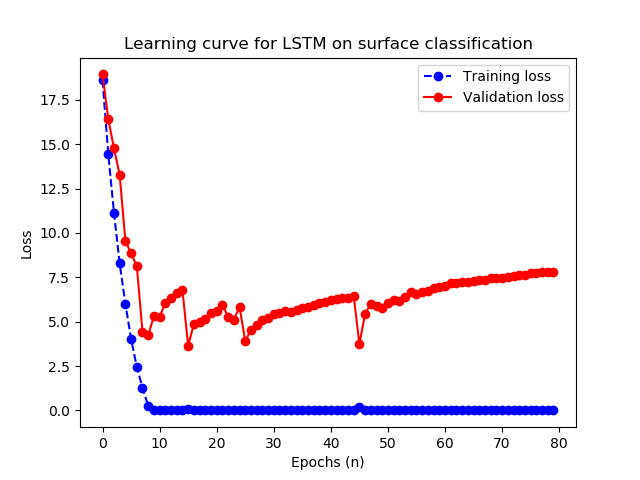

In [13]:
# graphical results
plt.figure()
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.title("Learning curve for LSTM on surface classification")
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

<IPython.core.display.Javascript object>


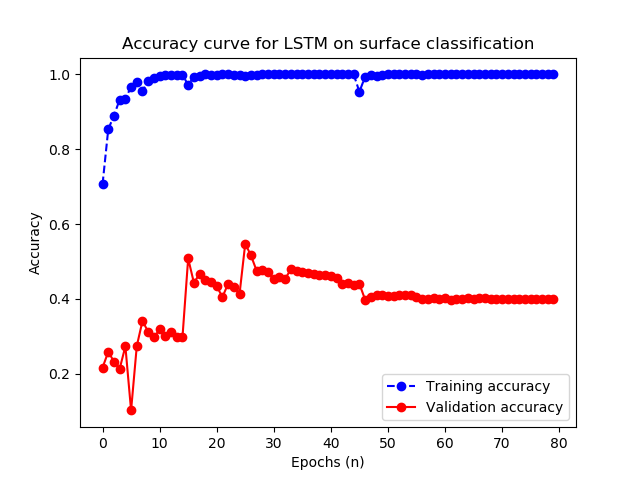

In [14]:
plt.figure()
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.title("Accuracy curve for LSTM on surface classification")
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [15]:
_, accuracy =  model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)

In [16]:
accuracy

0.39978904

We see low success with classification, likely becuase individual trials were more similar than different trials on the same surfaces. Our model is clearly overfitting to this data. 